# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
import pickle
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

#### a) Load the Data

In [74]:
# Load in the data
start_time = time.time()

azdias_chunks = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', chunksize=100000)
azdias = pd.concat(azdias_chunks)

end_time = time.time()
duration = end_time - start_time

print('{} seconds'.format(round(duration,2)))

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


192.46 seconds


In [3]:
azdias.shape

(891221, 366)

In [75]:
customers_chunks = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';',chunksize=50000)
customers = pd.concat(customers_chunks)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
customers.shape

(191652, 369)

When loading the data, we encounter an error. In particular columns 18 and 19 have mixed types. We will look into this later.

In [12]:
# Load the additional information
attr_values = pd.read_excel('./DIAS Attributes - Values 2017.xlsx',header=1,dtype=str)
attr_values_nan = pd.read_excel('./DIAS Attributes - Values 2017.xlsx',header=1)
attr_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx',header=1)

Let's take a look at the data.

In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [9]:
drop_extra_columns = list(x for x in customers.columns if x not in azdias.columns)
drop_extra_columns

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

In [10]:
customers.drop(columns=drop_extra_columns,inplace=True)
customers.shape

(191652, 366)

In [11]:
[x for x in customers.columns if x not in azdias.columns]

[]

We can confirm that the 3 extra columns in the customer data is ```PRODUCT_GROUP```, ```CUSTOMER_GROUP``` and ```ONLINE_PURCHASE``` which we removed. <br>
There are missing values (NaN) that we will need to deal with when preprocessing the data.

In [12]:
attr_values.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,nan,nan,0,no classification possible
NaN,nan,nan,1,passive elderly
NaN,nan,nan,2,cultural elderly
NaN,nan,nan,3,experience-driven elderly


In [13]:
attr_values.reset_index(drop=True,inplace=True)
attr_values.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,nan,nan,0,no classification possible
2,nan,nan,1,passive elderly
3,nan,nan,2,cultural elderly
4,nan,nan,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,nan,nan,1,< 30 years
7,nan,nan,2,30 - 45 years
8,nan,nan,3,46 - 60 years
9,nan,nan,4,> 60 years


In [14]:
attr_info.head()

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [14]:
attr_info.reset_index(drop=True,inplace=True)
attr_info.head(10)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [16]:
datasets = {'azdias':azdias,'customers':customers,'attr_values':attr_values,'attr_info':attr_info}

for k,v in datasets.items():
    print('{} has (rows, columns) -> {}'.format(k,v.shape))

azdias has (rows, columns) -> (891221, 366)
customers has (rows, columns) -> (191652, 366)
attr_values has (rows, columns) -> (2258, 4)
attr_info has (rows, columns) -> (313, 4)


In [17]:
pd.set_option('display.max_rows', None)
azdias.dtypes

LNR                              int64
AGER_TYP                         int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                

In [18]:
pd.reset_option('max_rows')

Most columns are float or int types. Let's make a list of the object columns.

In [19]:
object_cols = list(azdias.select_dtypes(['object']).columns)
object_cols

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

#### b) Pre-Processing Data

 - **Dealing with inconsistent data types**

Recall that we had inconsistent types for columns 18 and 19 when reading in the azias and customers data. We also see that there are other columns of type object (str). Let's look into this.

In [20]:
for col in object_cols:
    print('{} col has values: \n {} \n'.format(col,azdias.loc[:,col].unique()))

CAMEO_DEU_2015 col has values: 
 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX'] 

CAMEO_DEUG_2015 col has values: 
 [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X'] 

CAMEO_INTL_2015 col has values: 
 [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX'] 

D19_LETZTER_KAUF_BRANCHE col has values: 
 [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HAUS

```CAMEO_DEU_2015``` has null values, string values as well as 'X' value. No warning message was printed for this column as all values are all string values. 

```CAMEO_DEUG_2015``` and ```CAMEO_INTL_2015``` has null values, string values, float values as well as values of 'X' and 'XX'. This explains the mix type error message.

Nothing seems out of the ordinary with the other object (str) columns and they do have missing values. 

Create helper functions to:
- replace the odd values in each of the columns with null
- convert the mixed types to int

In [15]:
def replace_with_nan(df, col_list, value_list):
    ''' This function takes in a dataframe replacing a given list of values with null values in the columns specified
    
    Input: 
        df {dataframe} -- a dataframe
        col_list {list} -- a list of columns within the dataframe (values in these columns will be replaced)
        value_list {list} -- a list of values (value_list values will be replaced with null)
    
    Returns:
        transform_df {dataframe} -- a transformed df where values in value_list within the columns of col_list have been 
                                    replaced by null values
    '''
   
    try:
        for col in col_list:
            df[col] = df[col].replace(value_list,np.nan)
    except:
        print('Column {} not found. No replacement done.'.format(col))
        
    return df

fix_cols = ['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015']

In [16]:
def convert_to_numeric(df, col_list):
    ''' This function takes in a dataframe and converts the values in the columns specified to numeric values
    
    Input: 
        df {dataframe} -- a dataframe
        col_list {list} -- a list of columns within the dataframe (values in these columns will be converted to numeric)
    
    Returns:
        transform_df {dataframe} -- a transformed df where the values in the columns specified are converted into numeric values
    '''
    try:
        for col in col_list:
            df[col] = pd.to_numeric(df[col],errors='coerce')
    except:
        print('Column {} not found. No replacement done.'.format(col))
        
    return df

convert_cols = ['CAMEO_DEUG_2015','CAMEO_INTL_2015']    

In [23]:
#fix cameo cols and convert to numeric on azdias

azdias_processed = azdias.copy()
azdias_processed = replace_with_nan(azdias_processed,fix_cols,['X','XX'])
azdias_processed = convert_to_numeric(azdias_processed,convert_cols)

#test
for col in fix_cols:
    print('{} has values: \n {} \n'.format(col,azdias_processed.loc[:,col].unique()))

object_cols = list(azdias_processed.select_dtypes(['object']).columns)
object_cols

CAMEO_DEU_2015 has values: 
 [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'] 

CAMEO_DEUG_2015 has values: 
 [ nan   8.   4.   2.   6.   1.   9.   5.   7.   3.] 

CAMEO_INTL_2015 has values: 
 [ nan  51.  24.  12.  43.  54.  22.  14.  13.  15.  33.  41.  34.  55.  25.
  23.  31.  52.  35.  45.  44.  32.] 



['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']

In [24]:
#fix cameo cols and convert to numeric on customers

customers_processed = customers.copy()
customers_processed = replace_with_nan(customers_processed,fix_cols,['X','XX'])
customers_processed = convert_to_numeric(customers_processed,convert_cols)

#test
for col in fix_cols:
    print('{} has values: \n {} \n'.format(col,customers_processed.loc[:,col].unique()))

object_cols = list(customers_processed.select_dtypes(['object']).columns)
object_cols

CAMEO_DEU_2015 has values: 
 ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C' '5A'
 '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D' '6F' '4D'] 

CAMEO_DEUG_2015 has values: 
 [  1.  nan   5.   4.   7.   3.   9.   2.   6.   8.] 

CAMEO_INTL_2015 has values: 
 [ 13.  nan  34.  24.  41.  23.  15.  55.  14.  22.  43.  51.  33.  25.  44.
  54.  32.  12.  35.  31.  45.  52.] 



['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']

 - **Dealing with missing values**

Using the attribute values file we'll check which attribute values correspond to unknown / missing values so that we can convert them into null values.

In [17]:
def contains_unknown(str_series):
    ''' This function takes in a series of strings and determines whether each of them contains the word 'missing' or 'unknown'
        returning a list of True and False value
    
    Input: 
        str_series {series} -- a series

    Returns:
        return_list {list} -- a list of True and False values. True if 'missing' or 'unknown' is in the string, False if not.
    '''
    return_list = []
    for n in range(len(str_series)):
        s1 = 'unknown'
        s2 = 'missing'
        if s1 in str_series[n] or s2 in str_series[n]:
            return_list.append(True)
        else:
            return_list.append(False)
            
    return return_list

In [18]:
attr_values['Missing_or_unknown'] = contains_unknown(attr_values['Meaning'])

In [19]:
unknown_values = attr_values[(attr_values['Missing_or_unknown']) & (attr_values['Attribute']!='nan')].copy().reset_index(drop=True)

unknown_values['List_Values']=unknown_values.apply(lambda x: [int(i) for i in x[2].split(',')],axis=1)

replace_values=pd.DataFrame(unknown_values['List_Values'].values,index=unknown_values['Attribute'].values,columns=['Null_Values'])

replace_values.head(10)

,Null_Values
AGER_TYP,[-1]
ALTERSKATEGORIE_GROB,"[-1, 0]"
ALTER_HH,[0]
ANREDE_KZ,"[-1, 0]"
BALLRAUM,[-1]
BIP_FLAG,[-1]
CAMEO_DEUG_2015,[-1]
CAMEO_DEUINTL_2015,[-1]
CJT_GESAMTTYP,[0]
D19_KK_KUNDENTYP,[-1]


Now we can determine how many of our values are null and decide how we want to deal with them.

In [28]:
azdias_processed.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [29]:
#replace unknown values with nan

for index,row in replace_values.iterrows():
    replace_with_nan(azdias_processed,[index],row['Null_Values'])
    
#the first column is a line number so we will delete it
azdias_processed.drop(columns=['LNR'],inplace=True)

azdias_processed.head(20)

Column BIP_FLAG not found. No replacement done.
Column CAMEO_DEUINTL_2015 not found. No replacement done.
Column D19_KK_KUNDENTYP not found. No replacement done.
Column GEOSCORE_KLS7 not found. No replacement done.
Column HAUSHALTSSTRUKTUR not found. No replacement done.
Column KBA13_CCM_1400_2500 not found. No replacement done.
Column SOHO_FLAG not found. No replacement done.
Column WACHSTUMSGEBIET_NB not found. No replacement done.


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,3.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,NaN,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,0.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,1.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,0.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


In [30]:
#replace unknown values with nan

for index,row in replace_values.iterrows():
    replace_with_nan(customers_processed,[index],row['Null_Values'])
    
#the first column is a line number so we will delete it
customers_processed.drop(columns=['LNR'],inplace=True)

customers_processed.head(20)

Column BIP_FLAG not found. No replacement done.
Column CAMEO_DEUINTL_2015 not found. No replacement done.
Column D19_KK_KUNDENTYP not found. No replacement done.
Column GEOSCORE_KLS7 not found. No replacement done.
Column HAUSHALTSSTRUKTUR not found. No replacement done.
Column KBA13_CCM_1400_2500 not found. No replacement done.
Column SOHO_FLAG not found. No replacement done.
Column WACHSTUMSGEBIET_NB not found. No replacement done.


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,NaN,9.0,NaN,3,1,4
2,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
5,1.0,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3
6,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,4.0,3.0,4.0,2.0,6.0,9.0,7.0,1,1,4
7,1.0,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,0.0,...,3.0,1.0,2.0,1.0,6.0,9.0,3.0,3,1,4
8,2.0,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,2.0,...,NaN,8.0,11.0,9.0,6.0,3.0,4.0,3,2,4
9,1.0,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,5.0,1,1,3


> <font color=grey> **Column Nullity**</font>

Let's see how much missing data we have in each column.

In [20]:
def column_nullity(df):
    
    ''' This function takes in a dataframe and calculates the percentage null values in each column
    
    Input: 
        df {dataframe} -- a dataframe
        
    Returns:
        df_col_null {dataframe} -- a dataframe with the number and percentage of missing values for each column
    '''

    total = df.shape[0]
    null_col_values = df.isnull().sum()
    pct_null_col = np.round(null_col_values/total*100,2)

    null_col_dict = {'Percent' : pct_null_col.values}

    df_col_null = pd.DataFrame(null_col_dict,index=null_col_values.index)
    df_col_null.sort_values(by='Percent',inplace=True,ascending=False)
    
    return df_col_null

In [32]:
azdias_col_null = column_nullity(azdias_processed)
customers_col_null = column_nullity(customers_processed)

In [33]:
both_null = azdias_col_null.merge(customers_col_null, left_index=True, right_index=True, suffixes=('_azdias','_customers'))
both_null['Percent_max'] = both_null.apply(np.max,axis=1)
both_null.sort_values(by='Percent_max',inplace=True,ascending=False)
both_null.head(40)

,Percent_azdias,Percent_customers,Percent_max
ALTER_KIND4,99.86,99.88,99.88
TITEL_KZ,99.76,98.79,99.76
ALTER_KIND3,99.31,99.33,99.33
ALTER_KIND2,96.69,97.34,97.34
ALTER_KIND1,90.90,93.86,93.86
AGER_TYP,76.02,48.06,76.02
EXTSEL992,73.40,44.50,73.40
KK_KUNDENTYP,65.60,58.41,65.60
KBA05_BAUMAX,53.47,57.15,57.15
ALTER_HH,34.81,35.87,35.87


In [34]:
drop_columns=list(both_null[both_null['Percent_max']>30].index)
drop_columns

['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'ALTER_HH',
 'KKK',
 'REGIOTYP']

Let's remove these columns from both datasets.

In [35]:
azdias_processed.drop(columns=drop_columns,inplace=True)
customers_processed.drop(columns=drop_columns,inplace=True)

In [36]:
azdias_processed.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [37]:
customers_processed.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9.0,NaN,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,...,NaN,6.0,6.0,3.0,NaN,9.0,NaN,3,1,4
2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,1.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


> <font color=grey> **Row Nullity**</font>

In [21]:
def row_nullity(df):
    
    ''' This function takes in a dataframe and calculates the percentage null values for each row
    
    Input: 
        df {dataframe} -- a dataframe
        
    Returns:
        df_row_null {dataframe} -- a dataframe with the number and percentage of missing values for each row
    '''

    total_row = df.shape[1]
    null_row_values = df.isnull().sum(axis=1)
    pct_null_row = np.round(null_row_values/total_row*100,2)

    null_row_dict = {'Percent' : pct_null_row.values}

    df_row_null = pd.DataFrame(null_row_dict,index=null_row_values.index)
    df_row_null.sort_values(by='Percent',inplace=True,ascending=False)
    
    return df_row_null

In [39]:
azdias_row_null = row_nullity(azdias_processed)

Text(0.5,0,'Percentage missing data')

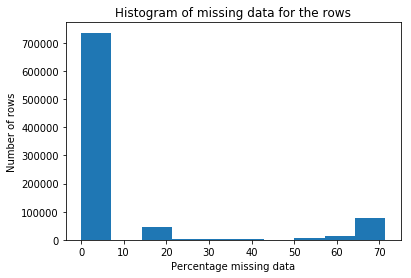

In [40]:
plt.hist(azdias_row_null['Percent'], bins = 10)
plt.title('Histogram of missing data for the rows')
plt.ylabel('Number of rows')
plt.xlabel('Percentage missing data')

In [41]:
azdias_row_null[azdias_row_null['Percent'] > 10].shape

(154006, 1)

In [42]:
rows_to_delete = azdias_row_null[azdias_row_null['Percent'] > 10]
rows_to_delete.head()

,Percent
826869,71.39
537799,71.39
350182,71.10
373501,71.10
55664,71.10


In [43]:
print("% of row data that will remain: {}%".format(100-round((azdias_row_null[azdias_row_null['Percent'] > 10].shape[0]/azdias_row_null.shape[0]*100),2)))

% of row data that will remain: 82.72%


If we remove the rows (persons) that have more than 10% of the features missing, we still have sufficient data and will get more meaningful results as we won't impute more than 10% of the features for each person. 

In [44]:
azdias_processed = azdias_processed[~azdias_processed.index.isin(rows_to_delete.index)]
azdias_processed.shape

(737215, 353)

#### Encoding features

Since we have many features, we will need to perform PCA. Before we can perform PCA, we need to make sure that the values can be scaled. In order to scale values we need to:

- Make sure all values are numeric
- Impute missing values

In [45]:
list_object_cols = list(azdias_processed.select_dtypes(['object']).columns)
list_object_cols

['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']

In [46]:
for col in list_object_cols:
    print('{} has values: \n {} \n'.format(col,azdias_processed.loc[:,col].unique()))

CAMEO_DEU_2015 has values: 
 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '7A' '5D' '9E' '5C' '9B'
 '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6E' '6D' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'] 

D19_LETZTER_KAUF_BRANCHE has values: 
 [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_SONSTIGE' 'D19_BANKEN_GROSS' 'D19_VOLLSORTIMENT'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_LEBENSMITTEL' 'D19_HAUS_DEKO' 'D19_BEKLEIDUNG_REST'
 'D19_SAMMELARTIKEL' 'D19_TELKO_MOBILE' 'D19_REISEN' 'D19_BEKLEIDUNG_GEH'
 'D19_TECHNIK' 'D19_NAHRUNGSERGAENZUNG' 'D19_DIGIT_SERV' 'D19_LOTTO'
 'D19_RATGEBER' 'D19_TIERARTIKEL' 'D19_KINDERARTIKEL' 'D19_BIO_OEKO'
 'D19_FREIZEIT' 'D19_WEIN_FEINKOST' 'D19_GARTEN' 'D19_BILDUNG'
 'D19_BANKEN_LOKAL'] 

EINGEFUEGT_AM has values: 
 ['1992-02-10 00:00:00' '1992-02-12 00:00:00' '1997-0

In [47]:
defined_cols = [x for x in attr_info['Attribute'] if x in list_object_cols]
defined_cols

['OST_WEST_KZ', 'CAMEO_DEU_2015']

We don't have information about the ```D19_LETZTER_KAUF_BRANCHE``` and ```EINGEFUEGT_AM``` columns, so instead of guessing how to impute them we will drop them. 

In [48]:
undefined_cols = [x for x in list_object_cols if x not in defined_cols]
undefined_cols

['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

In [49]:
azdias_processed.drop(columns=undefined_cols,inplace=True)
azdias_processed.shape

(737215, 351)

In [50]:
customers_processed.drop(columns=undefined_cols,inplace=True)
customers_processed.shape

(191652, 351)

In [51]:
azdias_processed['OST_WEST_KZ'].replace(['O','W'],[0,1],inplace=True)
azdias_processed.loc[:,'OST_WEST_KZ'].unique()

array([1, 0])

In [52]:
customers_processed['OST_WEST_KZ'].replace(['O','W'],[0,1],inplace=True)
customers_processed.loc[:,'OST_WEST_KZ'].unique()

array([  1.,  nan,   0.])

In [53]:
unique_cameo_values = set(azdias_processed.loc[:,'CAMEO_DEU_2015'])
unique_cameo_values.pop()
unique_cameo_values = list(unique_cameo_values)
unique_cameo_values.sort()
unique_cameo_values

['1A',
 '1B',
 '1C',
 '1D',
 '1E',
 '2A',
 '2B',
 '2C',
 '2D',
 '3A',
 '3B',
 '3C',
 '3D',
 '4A',
 '4B',
 '4C',
 '4D',
 '4E',
 '5A',
 '5B',
 '5C',
 '5D',
 '5E',
 '5F',
 '6A',
 '6B',
 '6C',
 '6D',
 '6E',
 '6F',
 '7A',
 '7B',
 '7C',
 '7D',
 '7E',
 '8A',
 '8B',
 '8C',
 '8D',
 '9A',
 '9B',
 '9C',
 '9D',
 '9E']

In [54]:
number_list = list(range(1,len(unique_cameo_values)+1))

In [55]:
azdias_processed['CAMEO_DEU_2015'].replace(unique_cameo_values,number_list,inplace=True)
azdias_processed.loc[:,'CAMEO_DEU_2015'].unique()

array([ 36.,  16.,   6.,  26.,  38.,  14.,   9.,   1.,   5.,  43.,  31.,
        22.,  44.,  21.,  41.,   2.,  37.,  13.,  nan,  18.,  15.,  12.,
        19.,  32.,  40.,  29.,  28.,   8.,  33.,  42.,  34.,  23.,   4.,
        39.,  27.,  25.,  20.,  17.,  10.,   7.,  35.,  11.,  30.,  24.,
         3.])

In [56]:
customers_processed['CAMEO_DEU_2015'].replace(unique_cameo_values,number_list,inplace=True)
customers_processed.loc[:,'CAMEO_DEU_2015'].unique()

array([  1.,  nan,  22.,  16.,  32.,  11.,   4.,  44.,   9.,  14.,  26.,
        43.,  37.,  21.,  42.,  18.,  27.,  38.,  36.,  20.,  41.,  13.,
         6.,  12.,  24.,  31.,   5.,   8.,  33.,  19.,   7.,  28.,  35.,
        23.,  29.,  10.,  40.,  15.,   3.,   2.,  25.,  39.,  34.,  30.,
        17.])

In [57]:
pd.set_option('display.max_rows', None)
azdias_processed.dtypes

AKT_DAT_KL                     float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 float64
CAMEO_DEUG_2015                float64
CAMEO_INTL_2015                float64
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                      float64
CJT_TYP_5                      float64
CJT_TYP_6                      float64
D19_BANKEN_ANZ_12                int64
D19_BANKEN_ANZ_24                int64
D19_BANKEN_DATUM                 int64
D19_BANKEN_DIREKT                int64
D19_BANKEN_GROSS         

In [58]:
customers_processed.dtypes

AKT_DAT_KL                     float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 float64
CAMEO_DEUG_2015                float64
CAMEO_INTL_2015                float64
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                      float64
CJT_TYP_5                      float64
CJT_TYP_6                      float64
D19_BANKEN_ANZ_12                int64
D19_BANKEN_ANZ_24                int64
D19_BANKEN_DATUM                 int64
D19_BANKEN_DIREKT                int64
D19_BANKEN_GROSS         

In [59]:
pd.reset_option('max_rows')

In [ ]:
#Dump processed data as pickle objects
pickle.dump(azdias_processed, open("azdias_processed.pickle", "wb"))
pickle.dump(customers_processed, open("customers_processed.pickle", "wb"))

### Imputing null values

Now, we are ready to impute the null values.

In [2]:
#Reload processed data (rerun imports cell)
azdias_processed = pickle.load(open("azdias_processed.pickle", "rb"))
customers_processed = pickle.load(open("customers_processed.pickle", "rb"))

In [3]:
azdias_processed.shape

(737215, 351)

In [4]:
customers_processed.shape

(191652, 351)

In [5]:
imputer = Imputer(strategy='most_frequent')

In [6]:
azdias_final = pd.DataFrame(imputer.fit_transform(azdias_processed), columns=azdias_processed.columns)

In [7]:
customers_final = pd.DataFrame(imputer.transform(customers_processed), columns=customers_processed.columns)

In [8]:
print('Azdias null values: {}'.format(azdias_final.isnull().sum().sum()))
print('Customers null values: {}'.format(customers_final.isnull().sum().sum()))

Azdias null values: 0
Customers null values: 0


### Feature Scaling

Now we can scale the features to prepare it for PCA. Based on this [article](https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02) I will use a ```MinMaxScaler``` to transform the values so they fall in the range (0,1).

In [9]:
scaler = MinMaxScaler()
azdias_final = pd.DataFrame(scaler.fit_transform(azdias_final), columns = azdias_final.columns, index=azdias_final.index)
customers_final = pd.DataFrame(scaler.transform(customers_final), columns = customers_final.columns, index=customers_final.index)

In [10]:
azdias_final.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.0,0.84,0.020522,0.0,0.0,0.052632,0.032000,0.0,0.250,0.833333,...,1.0,0.7,0.833333,0.9,0.4,1.0,0.500,0.8,1.0,0.000
1,1.0,0.68,0.018657,0.0,0.0,0.026316,0.018667,0.0,0.250,0.166667,...,0.5,0.8,0.666667,0.5,0.4,1.0,0.250,0.8,1.0,0.250
2,0.0,0.52,0.001866,0.0,0.0,0.000000,0.005333,0.0,0.125,0.500000,...,0.0,0.6,0.750000,1.0,1.0,1.0,0.875,0.4,1.0,0.375
3,0.0,0.56,0.005597,0.0,0.0,0.105263,0.008000,0.0,0.375,0.166667,...,0.5,0.2,0.333333,0.3,0.2,1.0,0.375,0.6,0.0,0.250
4,0.0,0.40,0.009328,0.0,0.0,0.026316,0.005333,0.0,0.125,0.833333,...,0.5,0.9,0.500000,0.3,1.0,1.0,0.875,0.6,1.0,0.000


In [11]:
customers_final.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.0,0.40,0.001866,0.0,0.0,0.052632,0.002667,0.0,0.000,0.333333,...,0.75,0.4,0.166667,0.1,1.0,1.0,0.875,0.4,0.0,0.375
1,1.0,0.60,0.001866,0.0,0.0,0.078947,0.002667,0.0,0.375,0.833333,...,0.50,0.5,0.416667,0.2,1.0,1.0,0.375,0.4,0.0,0.375
2,0.0,0.00,0.001866,0.0,0.0,0.026316,0.002667,0.0,0.250,1.000000,...,1.00,0.9,1.000000,1.0,1.0,1.0,0.250,0.4,1.0,0.375
3,0.0,0.32,0.000000,0.0,0.0,0.000000,0.002667,0.0,0.000,1.000000,...,0.50,0.5,0.250000,0.1,1.0,1.0,0.875,0.0,0.0,0.375
4,0.0,0.56,0.013060,0.0,0.0,0.105263,0.018667,0.0,0.250,0.333333,...,1.00,0.2,0.333333,0.3,0.2,1.0,0.375,0.0,0.0,0.250


In [12]:
#Dump processed data as pickle objects
pickle.dump(azdias_final, open("azdias_processed.pickle", "wb"))
pickle.dump(customers_final, open("customers_processed.pickle", "wb"))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [4]:
#Reload processed data (rerun imports cell)
azdias_final = pickle.load(open("azdias_processed.pickle", "rb"))
customers_final = pickle.load(open("customers_processed.pickle", "rb"))

### Dimensionality reduction

Let's first do PCA without specifying the number of components to see how many components we will need so that the top ```n``` components explain at least 80% of the variance. 

In [45]:
def perform_PCA(n_components,df):
    ''' This function takes in a dataframe and performs PCA creating n_components
    
    Input: 
        n_components {int} -- an integer representing the number of principal components to create
        df {dataframe} -- a dataframe
        
    Returns:
        pca -- a pca object
        pca_df -- the transformed df with the n_components
    '''
    
    pca = PCA(n_components,random_state=1)
    pca_df = pca.fit_transform(df)
    
    return pca, pca_df

In [46]:
azdias_pca_n, azdias_pca_df_n = perform_PCA(None,azdias_final)

Text(0.5,1,'PCA - Explained Variance')

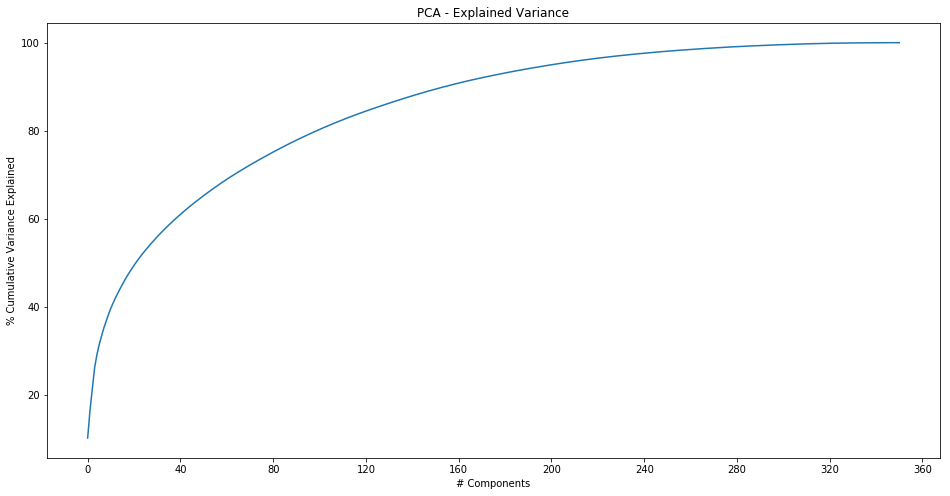

In [47]:
pca_var = azdias_pca_n.explained_variance_ratio_
pca_var_cumsum = np.cumsum(np.round(pca_var,5)*100)

plt.figure(figsize=(16,8))
plt.subplot(1,1,1)
plt.plot(np.arange(len(pca_var)),pca_var_cumsum)
plt.ylabel('% Cumulative Variance Explained')
plt.xlabel('# Components')
plt.xticks(np.linspace(0,50*round(len(pca_var)/50 + 1),10,endpoint=False))
plt.title('PCA - Explained Variance')

In [48]:
vars_df = pd.DataFrame(pca_var_cumsum,columns=['Variance'])
var_list = [75,80,85,90]

for var in var_list:
    expl_var = vars_df[vars_df['Variance'] > var].iloc[0,:]['Variance']
    print('{}% variance -> {} components'.format(round(expl_var,2),vars_df[vars_df['Variance'] == expl_var].index[0]+1))

75.15% variance -> 81 components
80.05% variance -> 100 components
85.01% variance -> 124 components
90.02% variance -> 155 components


Literature suggests choosing components so that 80% to 90% of the variance is explained. The above output shows that we need **100** components to explain at least **80%** of the variance. Since 100 components is already quite a lot, we will settle with 80% variance explained. 
<br><br> Let's redo the PCA with 100 components.

In [49]:
azdias_pca, azdias_pca_df = perform_PCA(100,azdias_final)

### Component Makeup

Each principal component gives a weighted linear combination of each of the original features. The larger the weight of a feature, the more important that feature is in that component. We can examine the makeup of each component.

In [50]:
numbers = ['Component_{}'.format(str(x)) for x in np.arange(1,len(azdias_pca.components_)+1)]
expl_var = pd.DataFrame(np.round(azdias_pca.explained_variance_ratio_,5),columns=['Explained_Variance'],index=numbers)
components = pd.DataFrame(np.round(azdias_pca.components_,5),columns=azdias_final.keys(),index=numbers)
component_df = pd.concat([expl_var,components],axis=1)
component_df.head()

,Explained_Variance,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
Component_1,0.10168,-0.11374,-0.01256,-0.00653,-0.00076,0.00445,0.00826,-0.00831,0.00019,-0.03093,...,-0.02984,-0.09530,-0.09273,-0.08581,-0.06622,0.01793,0.03064,-0.07653,-0.00910,0.01406
Component_2,0.06250,-0.00496,0.07645,0.00136,-0.00018,0.00984,0.00685,0.00148,-0.00021,0.00831,...,-0.00092,-0.11198,-0.06646,-0.01988,-0.12594,-0.04479,-0.00782,0.03636,0.02938,-0.05888
Component_3,0.04921,-0.00155,-0.00322,0.00159,0.00135,-0.00019,-0.00021,0.00190,0.00068,-0.01339,...,0.04254,0.00039,0.00250,0.00713,0.00726,-0.00591,-0.07678,-0.01772,0.01094,0.00038
Component_4,0.04794,-0.15664,-0.05219,0.00387,0.00082,-0.00106,0.00439,0.00513,0.00035,0.03488,...,0.01994,-0.07402,-0.09842,-0.10997,0.01189,0.01789,-0.03981,-0.03260,-0.01361,0.04917
Component_5,0.02997,-0.01409,0.00283,-0.00004,-0.00003,-0.00148,0.00126,-0.00020,0.00021,0.00278,...,0.00413,-0.00729,-0.02913,-0.06371,0.03317,-0.00072,0.00101,-0.03190,-0.51672,-0.01597


In [51]:
def show_pca_makeup(component_num,n_weights=20):
    features_list = azdias_final.columns.values

    row = component_df.iloc[component_num-1,1:]
    row_values = row.values

    comp = pd.DataFrame(list(zip(row,features_list)),columns=['weights','features'])

    comp['abs_weights']=comp['weights'].apply(lambda x: np.abs(x))
    sorted_weights = comp.sort_values('abs_weights',ascending=False).head(n_weights)

    ax=plt.subplots(figsize=(10,5))
    ax=sns.barplot(data=sorted_weights,
                   x='weights',
                   y='features',
                   palette='Purples_d')
    ax.set_title('PCA Component Makeup - Component {}'.format(str(component_num)))
    plt.show()
    
    display(row.to_frame().T)
    
    return_df = sorted_weights.merge(attr_info,left_on='features',right_on='Attribute',how='left')
    
    return return_df.loc[:,['weights','features','Description']]

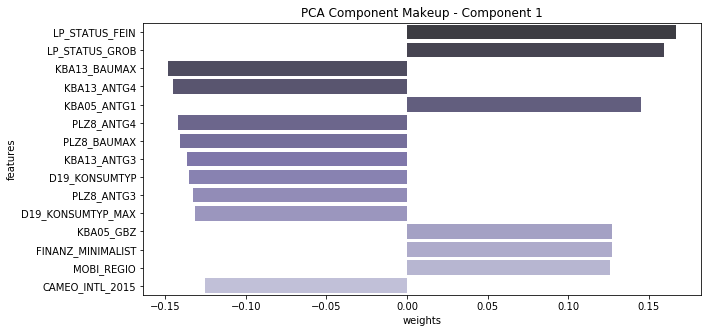

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
Component_1,-0.11374,-0.01256,-0.00653,-0.00076,0.00445,0.00826,-0.00831,0.00019,-0.03093,0.07016,...,-0.02984,-0.0953,-0.09273,-0.08581,-0.06622,0.01793,0.03064,-0.07653,-0.0091,0.01406


,weights,features,Description
0,0.16673,LP_STATUS_FEIN,social status fine
1,0.15950,LP_STATUS_GROB,social status rough
2,-0.14791,KBA13_BAUMAX,NaN
3,-0.14531,KBA13_ANTG4,NaN
4,0.14526,KBA05_ANTG1,number of 1-2 family houses in the cell
5,-0.14209,PLZ8_ANTG4,number of >10 family houses in the PLZ8
6,-0.14053,PLZ8_BAUMAX,most common building-type within the PLZ8
7,-0.13634,KBA13_ANTG3,NaN
8,-0.13496,D19_KONSUMTYP,consumption type
9,-0.13270,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8


In [52]:
show_pca_makeup(1,15)

### Clustering

Now that we have reduced the dimensionality of the data, we can cluster the data in component space. For K-Means Clustering, we will need to determine the number of clusters (k) to use. We want to choose a good k by ensuring that the data points are close to the cluster centre, but with enough clusters to seperate the data efficiently. We can look at how close each data point is to the cluster centre and compare it to the number of clusters. When we represent this visually it will create an elbow plot with the sharpest bend indicating where the distances between centroids and data points stops decreasing at a sharp rate, indicating a good choice for the number of clusters (k).

In [53]:
n_clusters = np.arange(1,15)
k_scores = [MiniBatchKMeans(i).fit(azdias_pca_df).score(azdias_pca_df) for i in n_clusters]

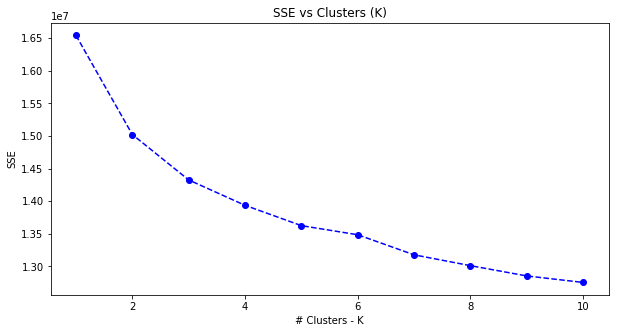

In [54]:
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
plt.ylabel('SSE')
plt.xlabel('# Clusters - K')
plt.title('SSE vs Clusters (K)')
plt.plot(n_clusters[:10], np.abs(k_scores)[:10], linestyle='--', marker='o', color='b')

By playing around and plotting the above graph for different end values of k, it looks like 6 clusters would be a good choice for k.

In [55]:
kmeans = KMeans(n_clusters=6,random_state=1)
azdias_kmeans_model = kmeans.fit(azdias_pca_df)
azdias_kmeans_label = azdias_kmeans_model.predict(azdias_pca_df)

In [56]:
azdias_kmeans_label[:20]

array([3, 1, 5, 4, 5, 1, 1, 1, 4, 2, 1, 1, 5, 3, 3, 1, 4, 1, 5, 3], dtype=int32)

Apply the dimensionality reduction on customers.

In [57]:
customers_pca_df = azdias_pca.transform(customers_final)

Predict the clusters for customers.

In [58]:
customers_kmeans_label = azdias_kmeans_model.predict(customers_pca_df)

In [59]:
customers_kmeans_label[:20]

array([5, 2, 5, 5, 4, 5, 0, 5, 2, 0, 4, 0, 0, 0, 2, 0, 0, 0, 4, 0], dtype=int32)

#### Compare Customer Clusters to Demographics Clusters

In [60]:
import collections

azdias_counts = collections.Counter(azdias_kmeans_label)
customers_counts = collections.Counter(customers_kmeans_label)

In [61]:
n_azdias = 891211
n_customers = 191652

for k, v in azdias_counts.items():
    azdias_counts[k] = v / n_azdias * 100
    
for k, v in customers_counts.items():
    customers_counts[k] = v / n_customers * 100

In [62]:
print(azdias_counts)
print(customers_counts)

Counter({5: 16.25181915393773, 0: 15.973546107487453, 1: 15.31096451906451, 2: 13.046742017322495, 3: 12.659291682889911, 4: 9.478226817218369})
Counter({5: 32.22142216100015, 0: 26.212614530503203, 1: 24.99530398847912, 2: 11.194769686723854, 4: 4.337027529063094, 3: 1.0388621042305846})


In [63]:
comparison_df = pd.DataFrame(columns=['Data','Cluster','Percentage'])
for k,v in azdias_counts.items():
    comparison_df = comparison_df.append({"Data": "German Population","Cluster": k+1, "Percentage": v},ignore_index=True)
for k,v in customers_counts.items():
    comparison_df = comparison_df.append({"Data": "Customer Population","Cluster": k+1, "Percentage": v},ignore_index=True)

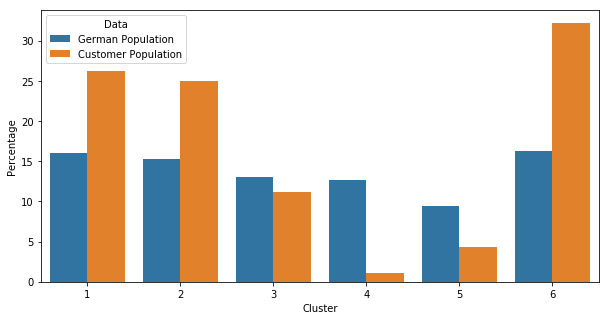

In [64]:
fig = plt.figure(figsize=(10,5))
sns.barplot(x="Cluster", y="Percentage", hue="Data", data=comparison_df)

Clusters 1, 2 and 6 are overrepresented in customers compared to the general German population, with cluster 6 being the most overrepresented. Clusters 3, 4 and 5 are underrepresented, with cluster 4 being the most underrepresented. We can therefore conclude that people belonging to cluster 4 are least likely to become customers, while customers belonging to cluster 6 are most likely.

In [66]:
cluster_centroids = pd.DataFrame(azdias_kmeans_model.cluster_centers_,columns=numbers)
cluster_centroids

,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,...,Component_91,Component_92,Component_93,Component_94,Component_95,Component_96,Component_97,Component_98,Component_99,Component_100
0,2.256345,0.878091,-0.084208,0.276106,0.018109,-0.057963,-0.035969,0.035302,-0.065834,0.034842,...,0.000684,0.000848,0.004666,0.001016,-0.005967,0.008390,-0.001303,-0.000986,-0.003909,-0.007943
1,-0.343879,0.017147,-0.186771,-1.512606,-0.068251,0.139982,0.093370,-0.049514,0.040917,0.030180,...,0.003423,-0.007613,-0.001171,-0.003540,-0.004026,-0.006922,0.004136,0.005169,0.003394,0.005275
2,-1.188791,-1.077884,-0.249126,1.089801,-0.150552,0.016772,0.083998,-0.138806,0.133460,0.004468,...,0.007209,0.004169,-0.013028,-0.012281,0.006645,0.001164,0.005179,0.001801,-0.000136,-0.011820
3,-2.356597,0.539426,0.231222,-0.111767,0.200524,-0.063416,-0.173142,0.226788,-0.203655,0.136933,...,-0.002899,0.003115,0.012594,0.009809,-0.009852,0.007532,-0.006749,-0.001834,-0.006948,0.007106
4,-0.282113,1.812966,0.274865,0.819392,-0.094860,-0.067649,0.063771,-0.295468,0.212533,-0.278917,...,-0.000295,-0.001947,-0.009463,-0.002412,0.009733,-0.003553,-0.002803,0.005573,0.005672,-0.000387
5,1.060969,-1.491614,0.118197,-0.111987,0.066425,0.000504,-0.022319,0.118984,-0.046243,-0.010271,...,-0.007251,0.001699,0.002680,0.005957,0.006322,-0.006455,0.000120,-0.007167,0.002859,0.007013


We can create a heatmap to show which characteristics define each cluster. Only the first 10 components are shown.

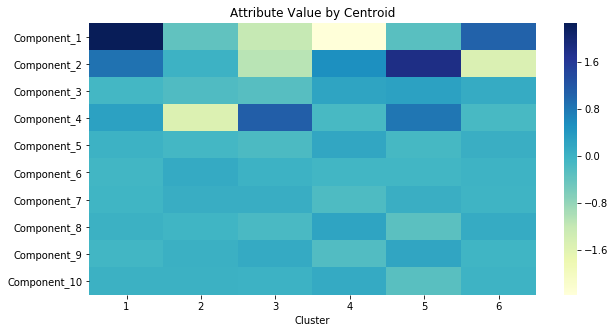

In [67]:
plt.figure(figsize = (10,5))
ax = sns.heatmap(cluster_centroids.iloc[:,:10].T, xticklabels=np.arange(1,7), cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
ax.set_title("Attribute Value by Centroid")
plt.show()

In [68]:
cluster_number = 6
component_numbers = np.arange(1,101)
cluster_attributes = pd.DataFrame({'Weights':cluster_centroids.iloc[cluster_number-1:cluster_number,:].T.values[:,0],'Component':component_numbers})
cluster_attributes.sort_values(by='Weights',inplace=True)
cluster_attributes.head(1)

,Weights,Component
1,-1.491614,2


We can confirm that cluster 6 (which are likely to be customers) is most influenced by component 2.

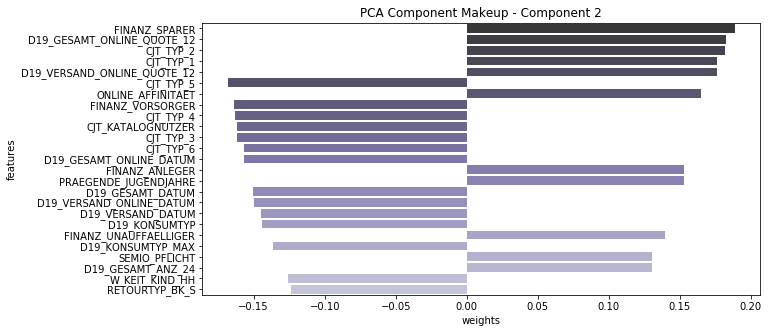

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
Component_2,-0.00496,0.07645,0.00136,-0.00018,0.00984,0.00685,0.00148,-0.00021,0.00831,-0.02891,...,-0.00092,-0.11198,-0.06646,-0.01988,-0.12594,-0.04479,-0.00782,0.03636,0.02938,-0.05888


,weights,features,Description
0,0.18892,FINANZ_SPARER,financial typology: money saver
1,0.18293,D19_GESAMT_ONLINE_QUOTE_12,amount of online transactions within all trans...
2,0.18215,CJT_TYP_2,NaN
3,0.17651,CJT_TYP_1,NaN
4,0.17604,D19_VERSAND_ONLINE_QUOTE_12,amount of online transactions within all trans...
5,-0.16832,CJT_TYP_5,NaN
6,0.16475,ONLINE_AFFINITAET,online affinity
7,-0.16397,FINANZ_VORSORGER,financial typology: be prepared
8,-0.16328,CJT_TYP_4,NaN
9,-0.16169,CJT_KATALOGNUTZER,NaN


In [69]:
show_pca_makeup(2,25)

In [70]:
cluster_number = 4
component_numbers = np.arange(1,101)
cluster_attributes = pd.DataFrame({'Weights':cluster_centroids.iloc[cluster_number-1:cluster_number,:].T.values[:,0],'Component':component_numbers})
cluster_attributes.sort_values(by='Weights',inplace=True)
cluster_attributes.head(1)

,Weights,Component
0,-2.356597,1


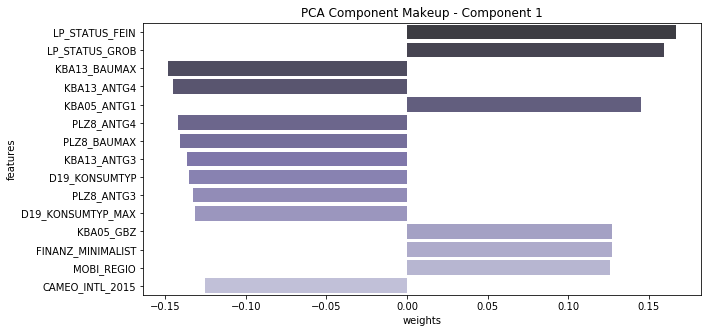

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
Component_1,-0.11374,-0.01256,-0.00653,-0.00076,0.00445,0.00826,-0.00831,0.00019,-0.03093,0.07016,...,-0.02984,-0.0953,-0.09273,-0.08581,-0.06622,0.01793,0.03064,-0.07653,-0.0091,0.01406


,weights,features,Description
0,0.16673,LP_STATUS_FEIN,social status fine
1,0.15950,LP_STATUS_GROB,social status rough
2,-0.14791,KBA13_BAUMAX,NaN
3,-0.14531,KBA13_ANTG4,NaN
4,0.14526,KBA05_ANTG1,number of 1-2 family houses in the cell
5,-0.14209,PLZ8_ANTG4,number of >10 family houses in the PLZ8
6,-0.14053,PLZ8_BAUMAX,most common building-type within the PLZ8
7,-0.13634,KBA13_ANTG3,NaN
8,-0.13496,D19_KONSUMTYP,consumption type
9,-0.13270,PLZ8_ANTG3,number of 6-10 family houses in the PLZ8


In [72]:
show_pca_makeup(1,15)

In [81]:
azdias_pred = pd.DataFrame(azdias_kmeans_label,columns=['Cluster'])
cust_pred = pd.DataFrame(customers_kmeans_label,columns=['Cluster'])

target_df = customers.iloc[cust_pred[cust_pred['Cluster'] == 6-1].index]
general_df = azdias.iloc[azdias_pred[azdias_pred['Cluster'] == 4-1].index]

In [88]:
attr_values_nan.ffill(inplace=True)

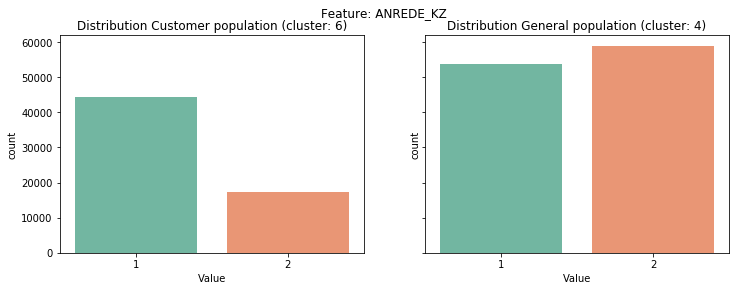

,Attribute,Description,Value,Meaning
0,ANREDE_KZ,gender,"-1, 0",unknown
1,ANREDE_KZ,gender,1,male
2,ANREDE_KZ,gender,2,female


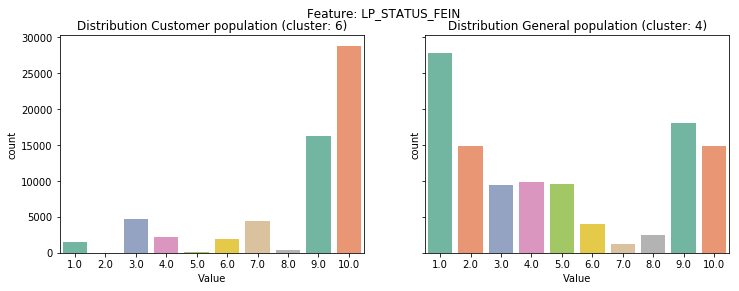

,Attribute,Description,Value,Meaning
0,LP_STATUS_FEIN,social status fine,1,typical low-income earners
1,LP_STATUS_FEIN,social status fine,2,orientationseeking low-income earners
2,LP_STATUS_FEIN,social status fine,3,aspiring low-income earners
3,LP_STATUS_FEIN,social status fine,4,villagers
4,LP_STATUS_FEIN,social status fine,5,minimalistic high-income earners
5,LP_STATUS_FEIN,social status fine,6,independant workers
6,LP_STATUS_FEIN,social status fine,7,title holder-households
7,LP_STATUS_FEIN,social status fine,8,new houseowners
8,LP_STATUS_FEIN,social status fine,9,houseowners
9,LP_STATUS_FEIN,social status fine,10,top earners


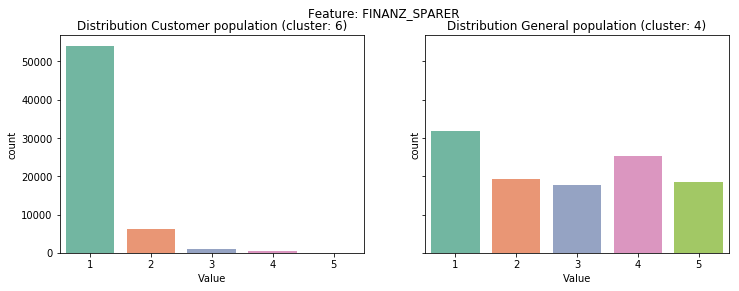

,Attribute,Description,Value,Meaning
0,FINANZ_SPARER,financial typology: money saver,-1,unknown
1,FINANZ_SPARER,financial typology: money saver,1,very high
2,FINANZ_SPARER,financial typology: money saver,2,high
3,FINANZ_SPARER,financial typology: money saver,3,average
4,FINANZ_SPARER,financial typology: money saver,4,low
5,FINANZ_SPARER,financial typology: money saver,5,very low


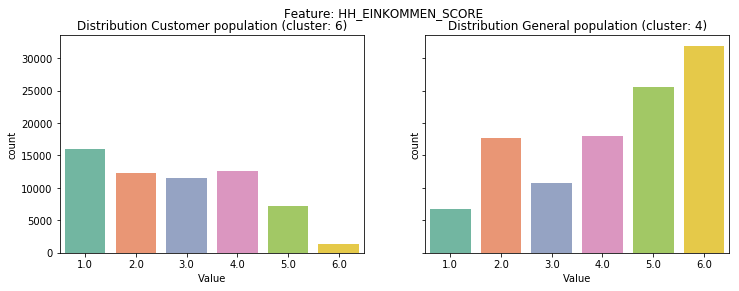

,Attribute,Description,Value,Meaning
0,HH_EINKOMMEN_SCORE,estimated household net income,"-1, 0",unknown
1,HH_EINKOMMEN_SCORE,estimated household net income,1,highest income
2,HH_EINKOMMEN_SCORE,estimated household net income,2,very high income
3,HH_EINKOMMEN_SCORE,estimated household net income,3,high income
4,HH_EINKOMMEN_SCORE,estimated household net income,4,average income
5,HH_EINKOMMEN_SCORE,estimated household net income,5,lower income
6,HH_EINKOMMEN_SCORE,estimated household net income,6,very low income


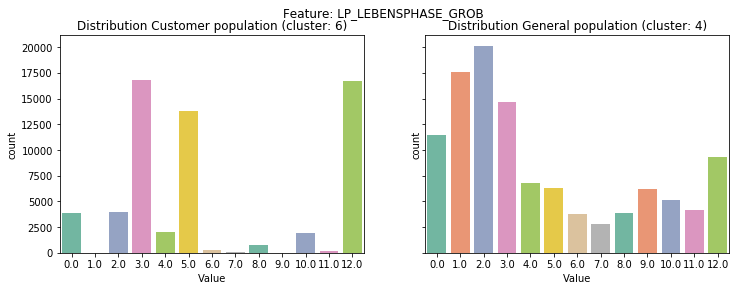

,Attribute,Description,Value,Meaning
0,LP_LEBENSPHASE_GROB,lifestage rough,1,single low-income- and average earners of youn...
1,LP_LEBENSPHASE_GROB,lifestage rough,2,single low-income- and average earners of high...
2,LP_LEBENSPHASE_GROB,lifestage rough,3,single high-income earners
3,LP_LEBENSPHASE_GROB,lifestage rough,4,single low-income- and average earner-couples
4,LP_LEBENSPHASE_GROB,lifestage rough,5,single high-income earner-couples
5,LP_LEBENSPHASE_GROB,lifestage rough,6,single parents
6,LP_LEBENSPHASE_GROB,lifestage rough,7,single low-income- and average earner-families
7,LP_LEBENSPHASE_GROB,lifestage rough,8,high-income earner-families
8,LP_LEBENSPHASE_GROB,lifestage rough,9,average earners of younger age from mulitperso...
9,LP_LEBENSPHASE_GROB,lifestage rough,10,low-income- and average earners of higher age ...


In [97]:
plot_cols = ['ANREDE_KZ','LP_STATUS_FEIN','FINANZ_SPARER','HH_EINKOMMEN_SCORE','LP_LEBENSPHASE_GROB']

for col in plot_cols:   
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2, sharey=True)
    sns.countplot(x=col, data=target_df, ax=ax1, palette="Set2")
    ax1.set_xlabel('Value')
    ax1.set_title('Distribution Customer population (cluster: 6)')
    sns.countplot(x=col, data=general_df, ax=ax2, palette="Set2")
    ax2.set_xlabel('Value')
    ax2.set_title(f'Distribution General population (cluster: 4)')
    fig.suptitle('Feature: {}'.format(col))
    plt.show()
    display(attr_values_nan[attr_values_nan['Attribute']==col].reset_index(drop=True))

The above shows that customers of the company are more likely to be higher-income single males with a high affinity to saving money. We can go deeper into other variables to refine target customers.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [14]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
mailout_train.shape

(42962, 367)

In [16]:
mailout_test.shape

(42833, 366)

Let's clean the training data.

In [17]:
#fix cameo cols and convert to numeric on training data

mailout_train_processed = mailout_train.copy()
mailout_train_processed = replace_with_nan(mailout_train_processed,fix_cols,['X','XX'])
mailout_train_processed = convert_to_numeric(mailout_train_processed,convert_cols)

#test
for col in fix_cols:
    print('{} has values: \n {} \n'.format(col,mailout_train_processed.loc[:,col].unique()))

object_cols = list(mailout_train_processed.select_dtypes(['object']).columns)
object_cols

CAMEO_DEU_2015 has values: 
 ['5D' '5B' '2D' '7B' '4C' '5C' nan '3D' '5A' '2C' '4A' '6B' '1A' '8D' '4B'
 '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B' '7E' '2A'
 '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E' '6A' '5F' '1B'] 

CAMEO_DEUG_2015 has values: 
 [  5.   2.   7.   4.  nan   3.   6.   1.   8.   9.] 

CAMEO_INTL_2015 has values: 
 [ 34.  32.  14.  41.  24.  33.  nan  25.  31.  22.  43.  13.  55.  23.  54.
  51.  45.  12.  44.  35.  15.  52.] 



['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']

In [18]:
#replace unknown values with nan

for index,row in replace_values.iterrows():
    replace_with_nan(mailout_train_processed,[index],row['Null_Values'])

Column BIP_FLAG not found. No replacement done.
Column CAMEO_DEUINTL_2015 not found. No replacement done.
Column D19_KK_KUNDENTYP not found. No replacement done.
Column GEOSCORE_KLS7 not found. No replacement done.
Column HAUSHALTSSTRUKTUR not found. No replacement done.
Column KBA13_CCM_1400_2500 not found. No replacement done.
Column SOHO_FLAG not found. No replacement done.
Column WACHSTUMSGEBIET_NB not found. No replacement done.


In [19]:
#drop columns with > 30% missing
drop_columns = ['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'ALTER_HH',
 'KKK',
 'REGIOTYP']

mailout_train_processed.drop(columns=drop_columns,inplace=True)

In [20]:
mailout_train_processed.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,1.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,4.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,1.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,1.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [21]:
#drop rows with more than 10% missing
mailout_train_row_null = row_nullity(mailout_train_processed)
rows_to_delete = mailout_train_row_null[mailout_train_row_null['Percent'] > 10]
mailout_train_processed = mailout_train_processed[~mailout_train_processed.index.isin(rows_to_delete.index)]
mailout_train_processed.shape

(33835, 355)

In [22]:
#remove undefined columns
undefined_cols = ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
mailout_train_processed.drop(columns=undefined_cols,inplace=True)

In [23]:
#encode 'OST_WEST_KZ'
mailout_train_processed['OST_WEST_KZ'].replace(['O','W'],[0,1],inplace=True)

In [27]:
#encode 'CAMEO_DEU_2015'
unique_cameo_values = set(mailout_train_processed.loc[:,'CAMEO_DEU_2015'])
unique_cameo_values.pop()
unique_cameo_values = list(unique_cameo_values)
unique_cameo_values.sort()
number_list = list(range(1,len(unique_cameo_values)+1))
mailout_train_processed['CAMEO_DEU_2015'].replace(unique_cameo_values,number_list,inplace=True)

In [28]:
mailout_train_processed.shape

(33835, 353)

Let's check the Response variable.

In [29]:
mailout_train_processed.groupby(['RESPONSE'])['LNR'].count()/mailout_train_processed['LNR'].count()*100

RESPONSE
0    98.770504
1     1.229496
Name: LNR, dtype: float64

We see that 1.2% of the individuals in the training data have taken up the offer. We therefore have severe class imbalance. As such our best metric to measure the accuracy would be ROC AUC as per this [article](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/).

In [30]:
LNR = mailout_train_processed['LNR']
y = mailout_train_processed['RESPONSE']

mailout_train_processed.drop(columns=['LNR','RESPONSE'],inplace=True) 
mailout_train_processed.shape

(33835, 351)

In [31]:
#impute missing values
imputer = Imputer(strategy='most_frequent')
mailout_train_final = pd.DataFrame(imputer.fit_transform(mailout_train_processed), columns=mailout_train_processed.columns)

In [32]:
#scale values
scaler = MinMaxScaler()
mailout_train_final = pd.DataFrame(scaler.fit_transform(mailout_train_final), columns = mailout_train_final.columns, index=mailout_train_final.index)

In [33]:
mailout_train_final.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.000,0.32,0.034247,0.0,0.0,0.041667,0.035230,0.0,0.250,0.666667,...,0.50,0.4,0.083333,0.0,1.0,1.0,0.285714,0.4,1.0,0.375
1,0.375,0.52,0.002283,0.0,0.0,0.083333,0.002710,0.0,0.125,0.666667,...,0.75,0.0,0.083333,0.0,0.6,1.0,0.857143,0.0,1.0,0.250
2,0.000,0.28,0.000000,0.0,0.0,0.000000,0.002710,0.0,0.375,0.000000,...,0.25,0.5,0.250000,0.1,1.0,1.0,0.142857,0.4,0.0,0.375
3,0.000,0.24,0.009132,0.0,0.0,0.083333,0.010840,0.0,0.375,0.166667,...,1.00,0.7,0.833333,1.0,1.0,1.0,0.000000,0.4,1.0,0.375
4,0.000,0.36,0.121005,0.0,0.0,0.041667,0.119241,0.0,0.250,0.500000,...,1.00,0.1,0.083333,0.0,1.0,1.0,0.285714,0.4,0.0,0.250


In [34]:
def best_estimator_roc(clf, param_grid, X=mailout_train_final, y=y):
    '''
    This function fits a classifier using GridSearchCV and calculates the ROC AUC metric
    
    Inputs:
        clf {classifier}: specified classifier to fit
        param_grid {dict}: classifier parameters used with GridSearchCV
        X {DataFrame}: features of the training dataframe
        y {DataFrame}: dataframe containing the labels of the training dataframe
            
    Returns:
        classifier: fitted classifier
    
    Output:
        execution_time
        ROC AUC metric
    '''
    start_time = time.time()
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    duration = np.round(time.time() - start_time,1)
    
    print('Execution time: {} seconds. \n'.format(str(duration)))
    
    print(grid.best_score_)
    
    return grid.best_estimator_

In [35]:
log_regression = LogisticRegression(random_state=1)
print(best_estimator_roc(log_regression,{}))

Execution time: 32.0 seconds. 

0.692143622065
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


We will use the logistic regression as the **base model**. Unless a model significantly outperforms logistic regression, we will choose simplicity over marginal accuracy as logistic regression is much easier to explain.

I will try different classifiers as documented [here](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

In [36]:
dec_tree = DecisionTreeClassifier(max_depth=5,random_state=1)
print(best_estimator_roc(dec_tree,{}))

Execution time: 8.2 seconds. 

0.76105646088
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


In [37]:
RF_classifier = RandomForestClassifier(max_depth=5,random_state=1)
print(best_estimator_roc(RF_classifier,{}))

Execution time: 3.8 seconds. 

0.698812859923
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


In [38]:
gb_classifier = GradientBoostingClassifier(random_state=1)
print(best_estimator_roc(gb_classifier, {}))

Execution time: 238.1 seconds. 

0.768053889313
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)


In [39]:
ada_classifier = AdaBoostClassifier(random_state=1)
print(best_estimator_roc(ada_classifier, {}))

Execution time: 85.0 seconds. 

0.758464179716
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=1)


Based on the results above, a boosting algorithm seems like a good option as we a significant improvement compared to the logistic regression base model. Let's try the famous, award-winning XGBoost model to see if we can get an even better result.

In [40]:
import sys
!conda install --yes --prefix {sys.prefix} xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.14
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    libxgboost-1.0.2           |       he1b5a44_1         2.8 MB  conda-forge
    py-xgboost-1.0.2           |   py36h9f0ad1d_1         2.2 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    xgboost-1.0.2              |   py36h831f99a_1          11 KB  conda-forge
    ------------

In [41]:
import xgboost as xgb

xgb.__version__

'1.0.2'

In [42]:
from xgboost import XGBClassifier

In [43]:
xgb_classifier = XGBClassifier(max_depth=5,random_state=1)
print(best_estimator_roc(xgb_classifier, {}))

Execution time: 250.3 seconds. 

0.750598491797
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=1, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)


Surprisingly, XGBoost performs slighlty worse than AdaBoost. Further, Adaboost executes much faster. Therefore, I will choose Adaboost and tune it further.

#### Different base models for AdaBoost

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_final,y,test_size=0.25)

In [72]:
pickle.dump(X_train, open("X_train.pickle", "wb"))
pickle.dump(y_train, open("y_train.pickle", "wb"))
pickle.dump(X_val, open("X_val.pickle", "wb"))
pickle.dump(y_val, open("y_val.pickle","wb"))

In [2]:
X_train = pickle.load(open("X_train.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))
X_val = pickle.load(open("X_val.pickle", "rb"))
y_val = pickle.load(open("y_val.pickle", "rb"))

In [68]:
ada_base = AdaBoostClassifier()
ada_decision_tree = AdaBoostClassifier(DecisionTreeClassifier())
ada_extra_tree = AdaBoostClassifier(ExtraTreeClassifier())
ada_log_reg = AdaBoostClassifier(LogisticRegression())

In [63]:
X = X_train.append(X_val)
y = y_train.append(y_val)

In [69]:
def score_model(mod, X, y, folds):
    cv = StratifiedKFold(n_splits=folds, shuffle=True)
    cv_estimate = cross_val_score(mod, X, y, cv=cv, scoring='roc_auc')
    return np.mean(cv_estimate), np.std(cv_estimate)

In [ ]:
models = [ada_base,ada_decision_tree,ada_extra_tree,ada_log_reg,log_reg,decision_tree]
model_names = ['Ada Base','Ada DecisionTree','Ada ExtraTree','Ada LogisticRegression','Logistic Regression','Decision Tree']

results = pd.DataFrame(index=model_names,columns=['roc_auc_mean','roc_auc_std'])

for name, model in zip(model_names,models):
    mean, std = score_model(model, X, y, 10)
    results.loc[name, 'roc_auc_mean'] = mean
    results.loc[name, 'roc_auc_std'] = std 

In [11]:
results

,roc_auc_mean,roc_auc_std
Base,0.771615,0.0451193
DecisionTree,0.514507,0.0223696
ExtraTree,0.502646,0.00833769
LogisticRegression,0.697246,0.0232423


#### Parameter Tuning

In [5]:
cv=StratifiedKFold(n_splits=10, shuffle=True)
ada=AdaBoostClassifier(random_state=1)
search_grid={'n_estimators':[25, 50, 100, 250],'learning_rate':[0.01, 0.1, 1]}
search=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='roc_auc',cv=cv,n_jobs=-1)

In [ ]:
search.fit(X,y)
print(search.best_params_)
print(search.best_score_)

In [18]:
print(search.best_estimator_)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=1)


Let's tune the benchmark Logistic Regression model.

In [9]:
logreg_cv=StratifiedKFold(n_splits=10, shuffle=True)
logreg=LogisticRegression(random_state=1)
param_grid={'C':[0.001, 0.01, 0.1, 1, 10, 100]}
logreg_search=GridSearchCV(estimator=logreg,param_grid=param_grid,scoring='roc_auc',cv=logreg_cv)

In [10]:
logreg_search.fit(X,y)
print(logreg_search.best_params_)
print(logreg_search.best_score_)

{'C': 0.1}
0.673735728599


In [8]:
ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,learning_rate=0.1, n_estimators=50, random_state=1)
logreg = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

mod_names = ['AdaBoost','Logistic Regression']
mods = [ada,logreg]

final_results = pd.DataFrame(index=mod_names,columns=['roc_auc_mean','roc_auc_std'])

for name, mod in zip(mod_names,mods):
    mean, std = score_model(mod, X, y, 10)
    final_results.loc[name, 'roc_auc_mean'] = mean
    final_results.loc[name, 'roc_auc_std'] = std 
    
final_results

,roc_auc_mean,roc_auc_std
AdaBoost,0.771838,0.0291231
Logistic Regression,0.707162,0.0357753


Now that we have tuned both the benchmark model as well as the chosen model, let's see how well they perform on unseen data.

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,shuffle=True)

In [53]:
ada_final = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1, n_estimators=50, random_state=1)
ada_final.fit(X_train,y_train)
ada_prob = ada_final.predict_proba(X_val)

In [71]:
logreg_final = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, 
                                  multi_class='ovr', n_jobs=1, penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
                                  verbose=0, warm_start=False)
logreg_final.fit(X_train,y_train)
logreg_prob = logreg_final.predict_proba(X_val)

In [72]:
logreg_final

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

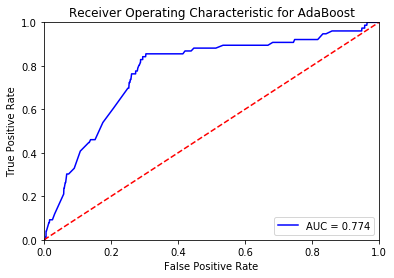

In [55]:
from sklearn.metrics import auc,roc_curve

fpr, tpr, threshold = roc_curve(y_val, ada_prob[:,1])
roc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for AdaBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

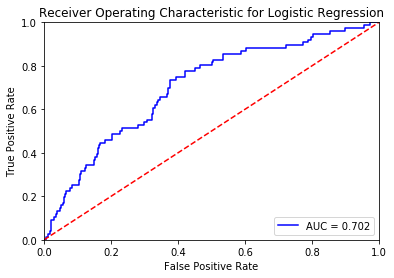

In [56]:
fpr, tpr, threshold = roc_curve(y_val, logreg_prob[:,1])
roc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic for Logistic Regression')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We get an average ROC AUC of 0.707 for the tuned Logistic Regression model and 0.772 for the tuned AdaBoost model. The best ROC AUC we could get from the AdaBoost model was 0.774 and got 0.702 when we have tested this on unseen (validation) data. Therefore the model should perform well on the unseen test data.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [10]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
mailout_test.shape

(42833, 366)

In [22]:
# fix cameo cols and convert to numberic
mailout_test_processed = mailout_test.copy()
mailout_test_processed = replace_with_nan(mailout_test_processed,fix_cols,['X','XX'])
mailout_test_processed = convert_to_numeric(mailout_test_processed,convert_cols)

In [23]:
# replace unknown values with nan
for index,row in replace_values.iterrows():
    replace_with_nan(mailout_test_processed,[index],row['Null_Values'])

Column BIP_FLAG not found. No replacement done.
Column CAMEO_DEUINTL_2015 not found. No replacement done.
Column D19_KK_KUNDENTYP not found. No replacement done.
Column GEOSCORE_KLS7 not found. No replacement done.
Column HAUSHALTSSTRUKTUR not found. No replacement done.
Column KBA13_CCM_1400_2500 not found. No replacement done.
Column SOHO_FLAG not found. No replacement done.
Column WACHSTUMSGEBIET_NB not found. No replacement done.


In [24]:
drop_columns = ['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'ALTER_HH',
 'KKK',
 'REGIOTYP']

mailout_test_processed.drop(columns=drop_columns,inplace=True)

In [25]:
#remove undefined columns
undefined_cols = ['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']
mailout_test_processed.drop(columns=undefined_cols,inplace=True)

In [26]:
#encode 'OST_WEST_KZ'
mailout_test_processed['OST_WEST_KZ'].replace(['O','W'],[0,1],inplace=True)

In [27]:
#encode 'CAMEO_DEU_2015'
unique_cameo_values = set(mailout_test_processed.loc[:,'CAMEO_DEU_2015'])
unique_cameo_values.pop()
unique_cameo_values = list(unique_cameo_values)
unique_cameo_values.sort()
number_list = list(range(1,len(unique_cameo_values)+1))
mailout_test_processed['CAMEO_DEU_2015'].replace(unique_cameo_values,number_list,inplace=True)

In [28]:
mailout_test_processed.shape

(42833, 352)

In [29]:
mailout_test_processed=mailout_test_processed.set_index('LNR')

In [30]:
mailout_test_processed.shape

(42833, 351)

In [31]:
mailout_test_processed.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1754,1.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1770,1.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
1465,9.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
1470,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
1478,1.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [32]:
#impute missing values
imputer = Imputer(strategy='most_frequent')
mailout_test_final = pd.DataFrame(imputer.fit_transform(mailout_test_processed), columns=mailout_test_processed.columns,index=mailout_test_processed.index)

In [33]:
mailout_test_final.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1754,1.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3.0,1.0,4.0
1770,1.0,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3.0,1.0,4.0
1465,9.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3.0,2.0,4.0
1470,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,2.0,6.0,6.0,3.0,6.0,9.0,2.0,3.0,2.0,4.0
1478,1.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4.0,2.0,4.0


In [34]:
#scale values
scaler = MinMaxScaler()
mailout_test_final = pd.DataFrame(scaler.fit_transform(mailout_test_final), columns = mailout_test_final.columns, index=mailout_test_final.index)

In [35]:
mailout_test_final.shape

(42833, 351)

In [34]:
mailout_test_final.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
LNR,,,,,,,,,,,,,,,,,,,,,
1754,0.00,0.24,0.005277,0.0,0.0,0.142857,0.005333,0.0,0.250,0.833333,...,1.00,0.4,0.416667,0.2,1.0,1.0,0.375,0.4,0.0,0.375
1770,0.00,0.00,0.052770,0.0,0.0,0.071429,0.056000,0.0,0.375,1.000000,...,0.25,0.4,0.083333,0.0,1.0,1.0,0.625,0.4,0.0,0.375
1465,1.00,0.44,0.005277,0.0,0.0,0.285714,0.005333,0.0,0.375,0.000000,...,0.75,0.8,0.416667,0.2,0.2,1.0,0.500,0.4,1.0,0.375
1470,0.75,0.00,0.002639,0.0,0.0,0.000000,0.002667,0.0,0.375,0.000000,...,0.50,0.5,0.416667,0.2,1.0,1.0,0.250,0.4,1.0,0.375
1478,0.00,0.52,0.002639,0.0,0.0,0.285714,0.002667,0.0,0.250,0.833333,...,0.25,0.1,0.250000,0.2,0.4,1.0,0.875,0.6,1.0,0.375


In [36]:
pickle.dump(mailout_test_final, open("test_final.pickle", "wb"))

In [40]:
test_final = pickle.load(open("test_final.pickle", "rb"))

In [57]:
ada_final = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1, n_estimators=50, random_state=1)
ada_final.fit(X,y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=1)

In [58]:
preds = ada_final.predict_proba(test_final)

In [59]:
preds[:10]

array([[ 0.67061336,  0.32938664],
       [ 0.67061336,  0.32938664],
       [ 0.7563202 ,  0.2436798 ],
       [ 0.74977984,  0.25022016],
       [ 0.74967652,  0.25032348],
       [ 0.75347438,  0.24652562],
       [ 0.75348574,  0.24651426],
       [ 0.67233251,  0.32766749],
       [ 0.67417775,  0.32582225],
       [ 0.74505482,  0.25494518]])

In [60]:
kaggle_df = pd.DataFrame({'LNR':mailout_test_final.index, 'RESPONSE':preds[:,1]})
kaggle_df.head()

,LNR,RESPONSE
0,1754,0.329387
1,1770,0.329387
2,1465,0.243680
3,1470,0.250220
4,1478,0.250323


In [61]:
kaggle_df.to_csv('submission.csv')